## Введение  
**Ситуация:** на платформе появилось много плохих комментариев.  
**Продуктовая задача:** избавиться от плохих комментариев.  
**Переход к ML задаче:**  
Разработать бинарный классификатор, который на вход будет принимать текст комментария, на выходе выдавать 2 класса - хороший/плохой комментарий.
**Метрики и ограничения:**  
Задача: максимизировать количество удаленных точно негативных комментариев.  
Ограничение: в 1 из 20 случаев мы имеем право ошибиться, то есть удалить хороший комментарий вместо плохого.  
2 метрики:  
- recall -  соотношение найденных плохих комментариев(если эта метрика = 1, значит мы нашли все плохие комментарии)
- precision - вероятность того, что если мы сказали, что комментарий является реально плохим, то он им реально является  
Поставим precision > 0.95.
  
**Итоговая ML задача**
- Разработать бинарный классификатор  
- Максимизировать recall  
- precision > 0.95  
Можно разметить данные самому, но это очень дорого, поэтому попробуем найти готовый датасет.
Прям так и пишем в гугл: "датасет токсичных комментариев"
находим https://www.kaggle.com/datasets/blackmoon/russian-language-toxic-comments

## Составление датасета
Можно разметить данные самому, но это очень дорого, поэтому попробуем найти готовый датасет.  
По запросу в гугл: "датасет токсичных комментариев" находим https://www.kaggle.com/datasets/blackmoon/russian-language-toxic-comments

## Необходимые библиотеки

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')  # Скачиваем стоп-слова
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
from sklearn.model_selection import GridSearchCV
import dill

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Анализ данных (EDA)

In [2]:
df = pd.read_csv("./labeled.csv", sep=",")

In [3]:
df.shape

(14412, 2)

In [4]:
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


  
Видим, что в столбце toxic данные типа float. Переведем их в тип int.
  

In [5]:
df["toxic"] = df["toxic"].apply(int)

In [6]:
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


Посмотрим распределение данных.

In [7]:
df["toxic"].value_counts()

toxic
0    9586
1    4826
Name: count, dtype: int64

Посмотрим, что подразумевается под токсичными комментариями в данном датасете.

In [8]:
for c in df[df["toxic"]==1]["comment"].head(5):
    print(c)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



In [9]:
for c in df[df["toxic"]==0]["comment"].head(5):
    print(c)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

Видим, что разметка данных не очень хорошая, так как даже в положительные комментарии попали достаточно негативные высказывания. Но работать будем с тем, что имеется.

В реальности для тестового датасета нужно использовать данные с таким же распределением, что и в продакшн системе, но у нас нет на самом деле никакго сервиса, поэтому возьмем 500 сэймплов из нашего датасета как тестовые и предположим, что распределение в них совпадает с нашей придуманной системой.
используем функцию train_test_split из библиотеки scikit-learn.

In [10]:
train_df, test_df = train_test_split(df, test_size=500)

Проверим, что у нас действительно 500 samples на тест.

In [11]:
test_df.shape

(500, 2)

Проверим распределение в test и в train, удостоверимся, что оно примерно одинаковое.

In [12]:
test_df["toxic"].value_counts()

toxic
0    317
1    183
Name: count, dtype: int64

In [13]:
train_df["toxic"].value_counts()

toxic
0    9269
1    4643
Name: count, dtype: int64

И там и там распределение 1 к 2.

Буду использовать самую простую модель - логистическую регрессию из библиотеки scikit-learn.  
Перед тем как подавать данные на вход, надо из текста сделать численные векторы, потому что сама модель принимает на вход вещественные векторы.

## Предобработка текста (text preprocessing)

**Этапы:**  
- Разбить текст на токены
- Удалить токены, не несущие смысловой информации (знаки пунктуации, стоп слова)  
- К каждому токену применить стемминг (stemming)(удалить окончания, привести все к нижнему регистру)

In [14]:
sentence_example = df.iloc[1]["comment"]

tokens = word_tokenize(sentence_example, language="russian")
tokens_without_punctuation = [i for i in tokens if i not in string.punctuation]
russian_stop_words = stopwords.words("russian")
tokens_without_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words]
snowball = SnowballStemmer(language="russian")

stemmed_tokens = [snowball.stem(i) for i in tokens_without_stop_words_and_punctuation]

In [15]:
print(f"Исходный текст: {sentence_example}")
print("--------------------")
print(f"Токены: {tokens}")
print("--------------------")
print(f"Токены без пунктуации: {tokens_without_punctuation}")
print("--------------------")
print(f"Токены без пунктуации и стоп-слов: {tokens_without_stop_words_and_punctuation}")
print("--------------------")
print(f"Токены после стемминга: {stemmed_tokens}")
print("--------------------")

Исходный текст: Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

--------------------
Токены: ['Хохлы', ',', 'это', 'отдушина', 'затюканого', 'россиянина', ',', 'мол', ',', 'вон', ',', 'а', 'у', 'хохлов', 'еще', 'хуже', '.', 'Если', 'бы', 'хохлов', 'не', 'было', ',', 'кисель', 'их', 'бы', 'придумал', '.']
--------------------
Токены без пунктуации: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'а', 'у', 'хохлов', 'еще', 'хуже', 'Если', 'бы', 'хохлов', 'не', 'было', 'кисель', 'их', 'бы', 'придумал']
--------------------
Токены без пунктуации и стоп-слов: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'хохлов', 'хуже', 'Если', 'хохлов', 'кисель', 'придумал']
--------------------
Токены после стемминга: ['хохл', 'эт', 'отдушин', 'затюкан', 'россиянин', 'мол', 'вон', 'хохл', 'хуж', 'есл', 'хохл', 'кисел', 'придума']
--------------------


Напишем функцию, чтобы обработать все значения.

In [16]:
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

Проверим ее на примере, чтобы понять правильно ли мы написали функцию.

In [17]:
tokenize_sentence(sentence_example)

['хохл',
 'эт',
 'отдушин',
 'затюкан',
 'россиянин',
 'мол',
 'вон',
 'хохл',
 'хуж',
 'есл',
 'хохл',
 'кисел',
 'придума']

## Тренировка модели (model Training)

Сейчас с развитием нейросетей много где используют эмбеддинги.  
Но мы будем использовать Tfidf векторизацию, так как это простой способ.

In [18]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

Наш векторайзер создан. Теперь мы можем его обучать.  
Для этого мы вызываем функцию fit_transform и передаем в нее список наших предложений из тренировочного датасета.  
Функция обучит vectorizer и вернет готовые фичи, которые можно будет передавать в модель машинного обучения.

In [19]:
features = vectorizer.fit_transform(train_df["comment"])

C:\Users\User\Documents\GitHub\toxic_comments\venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Наши фичи готовы, мы можем обучать модель логистической регрессии.

In [20]:
model = LogisticRegression(random_state=0)
model.fit(features, train_df["toxic"])

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Модель обучилась, теперь проверяем как она работает на тренировочном датасете.

In [21]:
model.predict(features[0])

array([0])

Модель выдвинула теорию, что комментарий не токсичный. Оценим теперь этот комментарий с точки зрения человека.

In [22]:
train_df["comment"].iloc[0]

'Совсем так. Если, закончив аренду, арендатор не сфоткает машину, то активные граждане с гвоздем создадут ему проблемы. Следующий арендатор отправит фотографии царапин, доказательств у предыдущего нет народная кара в виде ремонта и оплаты недополученной прибыли (стоимость ремонта количество часов простоя). Если фотографии после конца аренды? Повреждение навесить не получится. Каршеринг зло именно из-за подобных кабальных условий\n'

Комментарий не содержит каких-то плохих высказываний.

Все таки на вход модели подается текст, а не векторизированные данные. В scikit-learn  существует класс pipeline, который помогает соединить создание фичей и модель.

In [23]:
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0))
]
)

In [24]:
model_pipeline.fit(train_df["comment"], train_df["toxic"])

C:\Users\User\Documents\GitHub\toxic_comments\venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,steps,"[('vectorizer', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,<function <la...001A2DDE1D300>


In [25]:
model_pipeline.predict(["Привет, у меня все нормально"])

array([0])

In [26]:
model_pipeline.predict(["Иди нафиг!"])

array([1])

По этим двум примерам модель работает нормально. Надо измерить метрики.

## Измеряем метрики

In [27]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.9057971014492754

In [28]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.6830601092896175

Мы получили precision ниже, чем нас устраивает.  
На самом деле модель логистической регрессии возвращает не просто значения 0 или 1, она возвращает вероятности. После этого функция predict сравнивает эту вероятность с каким то порогом, и если вероятность больше порога, то она возвращает класс 1, иначе класс 0. И двигая этот порог, мы сможем менять precision и recall.

У библиотеки scikit-learn  есть функция для рисования precision-recall кривой.

In [29]:
prec, rec, thresholds = precision_recall_curve(
    y_true=test_df["toxic"],
    y_score=model_pipeline.predict_proba(test_df["comment"])[:, 1]
)

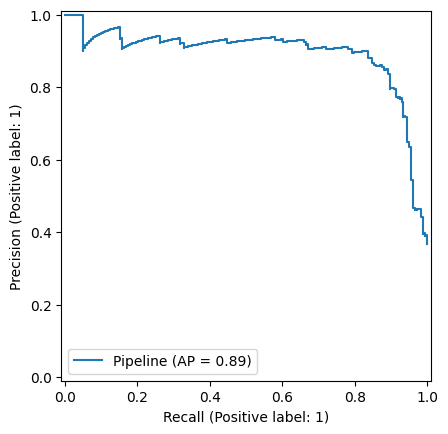

In [30]:
PrecisionRecallDisplay.from_estimator(
    estimator=model_pipeline,
    X=test_df["comment"],
    y=test_df["toxic"]
)
plt.show()

Зависимость precision от recall.  
Видно, что мы можем получить даже precision=1, но при этом очень низкий recall. То есть мы будем очень осторожны и будем удалять только те комментарии, в которых мы уверены, что они негативные. При этом большинство негативных комментариев мы не будем удалять (recall будет ну около 10%), но зато мы не удалим никакой хороший комментарий случайно.  
Найдем тот момент, когда precision>0.95

In [31]:
np.where(prec>0.95)

(array([471, 472, 473, 474, 475, 476, 477, 478, 479, 491, 492, 493, 494,
        495, 496, 497, 498, 499, 500]),)

In [51]:
thresholds[471]

np.float64(0.8582854031120298)

In [52]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1]>thresholds[471])

0.9642857142857143

In [53]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1]>thresholds[471])

0.14754098360655737

Реколл вышел такой, что удаляется 14% комментариев.

## Улучшение модели

In [35]:
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
         LogisticRegression(random_state=0),
         param_grid={'C': [0.1, 1, 10.]},
         cv = 3,
         verbose = 4
         )
    )
]
)

In [36]:
grid_pipeline.fit(train_df["comment"], train_df["toxic"])

C:\Users\User\Documents\GitHub\toxic_comments\venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END .............................C=0.1;, score=0.686 total time=   0.0s
[CV 2/3] END .............................C=0.1;, score=0.687 total time=   0.0s
[CV 3/3] END .............................C=0.1;, score=0.688 total time=   0.0s
[CV 1/3] END ...............................C=1;, score=0.837 total time=   0.0s
[CV 2/3] END ...............................C=1;, score=0.834 total time=   0.1s
[CV 3/3] END ...............................C=1;, score=0.839 total time=   0.1s
[CV 1/3] END ............................C=10.0;, score=0.864 total time=   0.2s
[CV 2/3] END ............................C=10.0;, score=0.863 total time=   0.2s
[CV 3/3] END ............................C=10.0;, score=0.864 total time=   0.1s


,steps,"[('vectorizer', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,<function <la...001A2DE428E00>


In [37]:
model_pipeline_c_10 = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=10.))
]
)

In [38]:
model_pipeline_c_10.fit(train_df["comment"], train_df["toxic"])

C:\Users\User\Documents\GitHub\toxic_comments\venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,steps,"[('vectorizer', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,<function <la...001A2DE4149A0>


In [39]:
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(
    y_true=test_df["toxic"],
    y_score=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1]
)

In [40]:
np.where(prec_c_10 > 0.95)

(array([456, 457, 458, 459, 462, 463, 464, 465, 466, 467, 468, 469, 470,
        471, 472, 473, 474, 475, 476, 477, 478, 479, 497, 498, 499, 500]),)

In [54]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1]>thresholds_c_10[456])

0.9534883720930233

In [55]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1]>thresholds_c_10[456])

0.22404371584699453

Теперь мы находим больше негативных комментариев(0.22>0.14), но с меньшей вероятностью (0.95<0.96), что мы удалили именно негативный комментарий, всего лишь изменив коэффициент регуляризациии.

## Чуть-чуть тестов

В большинстве случаев, модель работает верно.  
Напоминание:  
0 - хороший комментарий  
1 - плохой комментарий

In [43]:
model_pipeline_c_10.predict(["у меня все хорошо"])

array([0])

In [44]:
model_pipeline_c_10.predict(["хуйня"])

array([1])

In [45]:
model_pipeline_c_10.predict(["Сегодня прекрасный день, что за погодка!"])

array([0])

In [46]:
model_pipeline_c_10.predict(["пикми"])

array([0])

In [47]:
model_pipeline_c_10.predict(["Как можно быть такой красивой!?"])

array([0])

Но иногда модель может ошибаться, так как многие слова в русском могут употребляться как в плохом, так и в хорошем комментарии.  
Поэтому для более точного анализа надо будет применять более сложные модели.  
Пример со словом червь, в одном комментарии это существительное употребляется в хорошем смысле, во втором как оскорбление.

In [48]:
model_pipeline_c_10.predict(["Мама роди меня червем, я вижу вишни!"])

array([1])

In [49]:
model_pipeline_c_10.predict(["червь"])

array([1])

Бывают и ошибки такого порядка, их иногда можно найти тестами.

In [50]:
model_pipeline_c_10.predict(["Привет"])

array([1])

## Сохранение модели

In [59]:
with open('model.pkl', 'wb') as f:
    dill.dump(model_pipeline_c_10, f)